In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from dython.nominal import identify_nominal_columns
from dython.nominal import associations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer, make_column_selector as selector

In [2]:
diabetes = pd.read_csv('https://raw.githubusercontent.com/ryskgit/QTW_CaseStudy/main/Case%20Study%202/dataset_diabetes/diabetic_data.csv')

In [4]:
pd.set_option('display.max_columns', None)
diabetes.head(20)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,?,?,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
pd.reset_option("max_columns")

In [6]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [7]:
def custom_range(column):
    mean = column.mean()
    min = column.min()
    max = column.max()
    print(f'Mean : {mean}')
    print(f'Min : {min}')
    print(f'Max : {max}')

In [8]:
print(f'Simple Summary Statistics for Numeric Columns')
for i in diabetes.columns:
    if diabetes[i].dtypes == 'int64':
        print(f'{i}')
        custom_range(diabetes[i])
        print('------------')


Simple Summary Statistics for Numeric Columns
encounter_id
Mean : 165201645.6229782
Min : 12522
Max : 443867222
------------
patient_nbr
Mean : 54330400.694947235
Min : 135
Max : 189502619
------------
admission_type_id
Mean : 2.024006053102215
Min : 1
Max : 8
------------
discharge_disposition_id
Mean : 3.7156417664052825
Min : 1
Max : 28
------------
admission_source_id
Mean : 5.754436648782501
Min : 1
Max : 25
------------
time_in_hospital
Mean : 4.395986871843248
Min : 1
Max : 14
------------
num_lab_procedures
Mean : 43.09564098028811
Min : 1
Max : 132
------------
num_procedures
Mean : 1.339730361810428
Min : 0
Max : 6
------------
num_medications
Mean : 16.021844230882614
Min : 1
Max : 81
------------
number_outpatient
Mean : 0.36935715268360747
Min : 0
Max : 42
------------
number_emergency
Mean : 0.19783621248747127
Min : 0
Max : 76
------------
number_inpatient
Mean : 0.635565906098304
Min : 0
Max : 21
------------
number_diagnoses
Mean : 7.422606764538254
Min : 1
Max : 16
--

in 'discharge_disposition', no instances with value of '29'
in 'admission_source_id', no instance with value of '26'

array([[<AxesSubplot:title={'center':'encounter_id'}>,
        <AxesSubplot:title={'center':'patient_nbr'}>,
        <AxesSubplot:title={'center':'admission_type_id'}>,
        <AxesSubplot:title={'center':'discharge_disposition_id'}>],
       [<AxesSubplot:title={'center':'admission_source_id'}>,
        <AxesSubplot:title={'center':'time_in_hospital'}>,
        <AxesSubplot:title={'center':'num_lab_procedures'}>,
        <AxesSubplot:title={'center':'num_procedures'}>],
       [<AxesSubplot:title={'center':'num_medications'}>,
        <AxesSubplot:title={'center':'number_outpatient'}>,
        <AxesSubplot:title={'center':'number_emergency'}>,
        <AxesSubplot:title={'center':'number_inpatient'}>],
       [<AxesSubplot:title={'center':'number_diagnoses'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

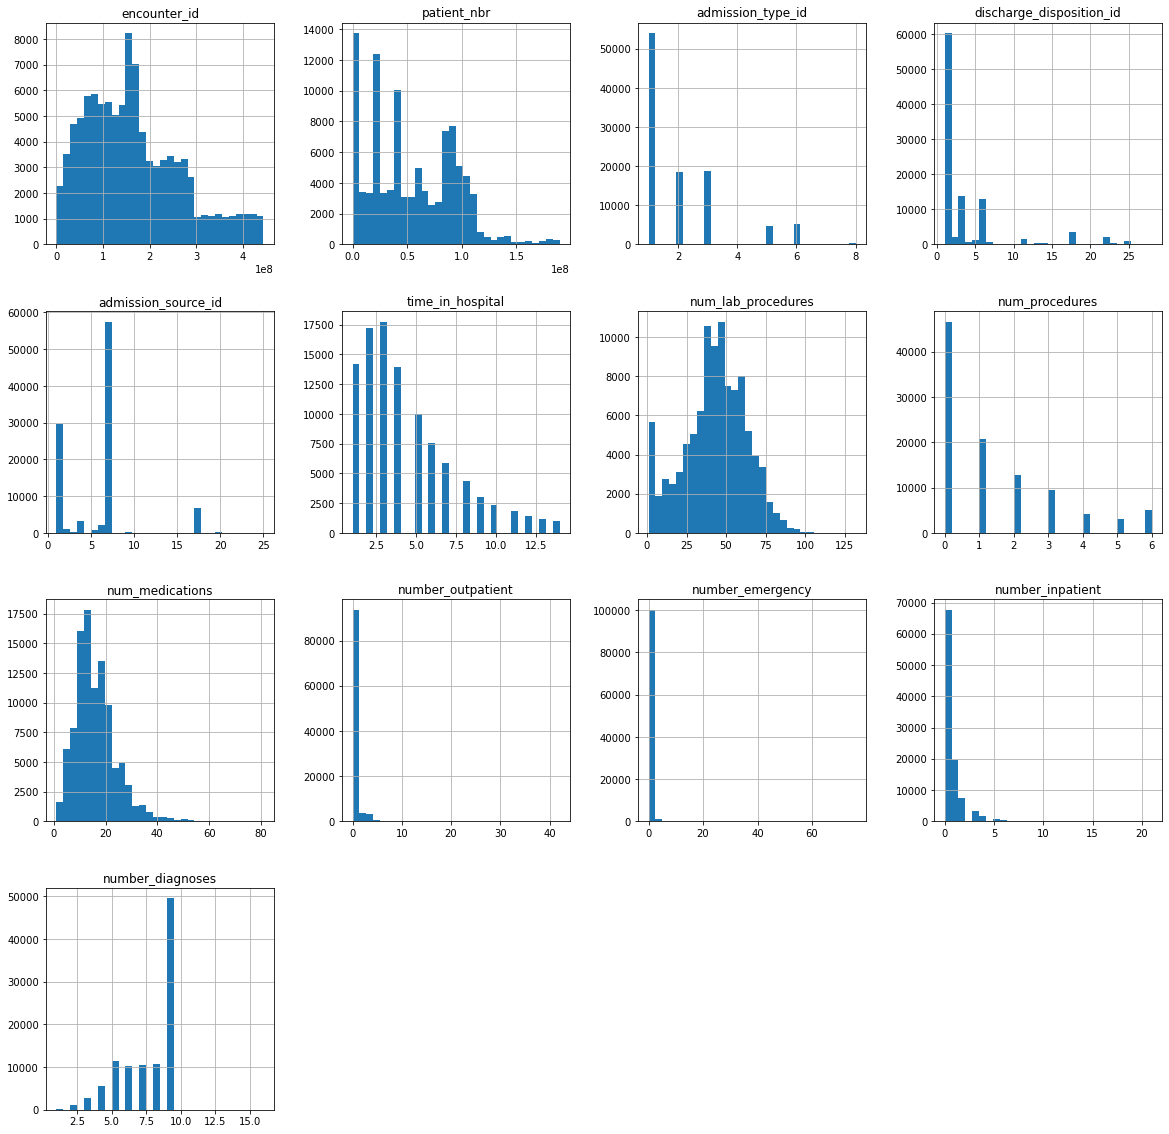

In [9]:
diabetes.hist(bins=30, figsize=(20, 20))

In [10]:
# value counts for each 'object' dtype
for i in diabetes.columns:
    if diabetes[i].dtypes == 'O':
        print(f'{i}')
        value = diabetes[i].value_counts()
        print(f'{value}')
        print('------------')
    else:
        pass

race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64
------------
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64
------------
age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64
------------
weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64
------------
payer_code
?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1


In [11]:
diabetes.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [12]:
# missing values, but doesn't register bc the values reflect '?' rather than Nan
diabetes.isna().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [13]:
# create copy to keep original dataset without manipulation
# missing values are displayed with a '?', so replace with Nan, which pandas can identify as a missing value
db_2 = diabetes.copy()
db_2[db_2=='?'] = np.nan

In [14]:
# 7 columns with missing values
db_2.isna().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [15]:
# remove single value columns, no predictive value
# remove weight as almost all values are missing
# remove missing values in diag_1,2,3 since they make up less than 1% of total number of rows
single_vals = db_2.columns[db_2.eq(db_2.iloc[0]).all()].tolist()
print(f"There are {len(single_vals)} columns with single values: {single_vals}")
print(f"Original data dimension: {db_2.shape}")
db_2.drop(columns=single_vals, inplace=True)
db_2.drop(columns = 'weight', inplace = True)
db_2.dropna(subset = ['diag_1', 'diag_2', 'diag_3'], inplace = True)
print(f"Final data dim after dropping aforementioned columns: {db_2.shape}")
print(f"There are {db_2.isna().sum().sum()} NA values and {db_2.duplicated().sum()} duplicated records")

There are 2 columns with single values: ['examide', 'citoglipton']
Original data dimension: (101766, 50)
Final data dim after dropping aforementioned columns: (100244, 47)
There are 91128 NA values and 0 duplicated records


In [16]:
# train/test split before imputing missing values
train, test = train_test_split(db_2, test_size=0.2, random_state=42)

In [17]:
# dimensions after 80/20 train/test split
print(f'Dimensions of train: {train.shape}')
print(f'Dimenstions of test: {test.shape}')

Dimensions of train: (80195, 47)
Dimenstions of test: (20049, 47)


In [18]:
# specific columns with missing values
# a bit concerned about weight, payer_code, and medical_specialty given the amount of missing values. might not be worth imputing?
print(f'Columns with missing values:')
miss_val_col = []
for i in train.columns:
    val = train[i].isna().sum()
    if val > 0:
        print(f'{i} : {val}')
        miss_val_col.append(i)

Columns with missing values:
race : 1760
payer_code : 31529
medical_specialty : 39618


In [19]:
# since all missing value columns are categorical, we can try imputing with the mode first
for i in miss_val_col:
    val = train[i].dtypes
    print(val)

object
object
object


In [20]:
# create copies of train,test to impute with mode of each var
test_mode = test.copy()
train_mode = train.copy()
for i in miss_val_col:
    train_mode[i] = train_mode[i].fillna(train_mode[i].mode()[0])
    test_mode[i] = test_mode[i].fillna(train_mode[i].mode()[0])

In [21]:
# missing values in 'mode' set is zero
train_mode.isna().sum().sum()

0

### Imputing via correlation and regression

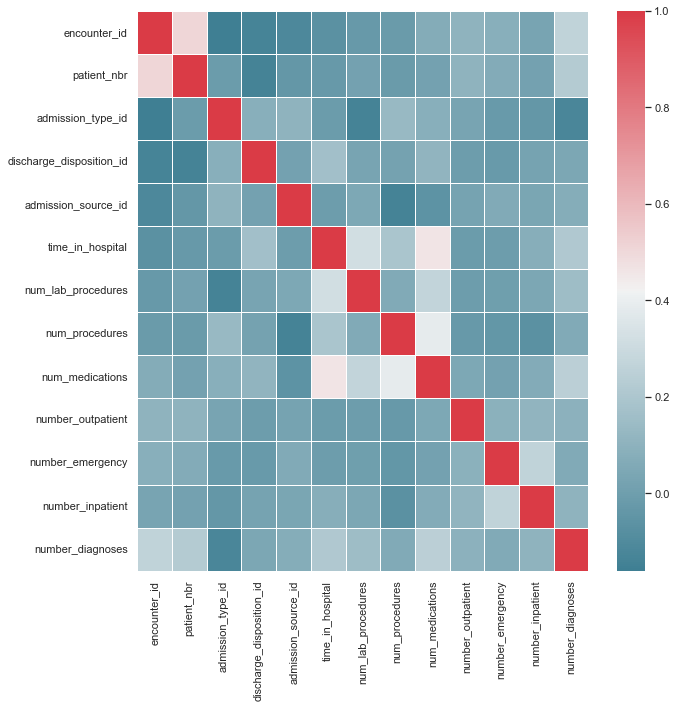

In [22]:
# Numeric Correlation Matrix, doesn't give much indication to corr of categorical variables
sns.set()
sns.set(style='darkgrid')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax= plt.subplots(figsize=(10,10))

sns.heatmap(train.corr(),cmap=cmap,fmt='.3f',linewidth=.5,ax=ax)
f.tight_layout()

In [23]:
cat_features = identify_nominal_columns(train)
len(cat_features)

34

In [24]:
%%capture
complete_correlation= associations(train, figsize=(25,25))

In [25]:
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

C:\Users\Rysk\AppData\Local\Temp\ipykernel_16088\1661098780.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,1.00,0.51,0.10,0.01,0.08,-0.16,-0.14,-0.12,-0.07,0.56,0.37,-0.03,-0.02,0.07,0.10,0.08,0.03,0.18,0.27,0.21,0.26,0.16,0.06,0.04,0.02,0.02,0.02,0.04,0.00,0.03,0.08,0.01,0.05,0.05,0.01,0.00,0.01,0.02,0.15,0.03,0.00,0.00,0.01,0.01,0.10,0.05,0.04
patient_nbr,0.51,1.00,0.16,0.00,0.07,-0.01,-0.14,-0.03,-0.03,0.30,0.33,0.01,-0.02,0.02,0.11,0.06,0.01,0.15,0.18,0.16,0.22,0.10,0.04,0.02,0.05,0.02,0.01,0.03,0.00,0.02,0.05,0.00,0.04,0.01,0.01,0.01,0.00,0.02,0.08,0.03,0.00,0.00,0.01,0.00,0.05,0.02,0.07
race,0.10,0.16,1.00,0.06,0.09,0.11,0.04,0.04,0.03,0.09,0.09,0.03,0.04,0.07,0.06,0.04,0.05,0.11,0.10,0.08,0.11,0.04,0.03,0.01,0.02,0.01,0.00,0.01,0.00,0.02,0.02,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.04,0.02,0.00,0.00,0.03,0.00,0.02,0.02,0.04
gender,0.01,0.00,0.06,1.00,0.08,0.02,0.02,0.01,0.03,0.06,0.08,0.00,0.06,0.02,0.01,0.02,0.01,0.17,0.15,0.39,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.02,0.02,0.01
age,0.08,0.07,0.09,0.08,1.00,0.05,0.11,0.08,0.10,0.15,0.23,0.03,0.14,0.14,0.03,0.11,0.08,0.24,0.20,0.20,0.21,0.03,0.09,0.06,0.03,0.01,0.00,0.02,0.00,0.04,0.05,0.01,0.03,0.02,0.00,0.00,0.00,0.00,0.06,0.01,0.00,0.00,0.00,0.00,0.05,0.04,0.03
admission_type_id,-0.16,-0.01,0.11,0.02,0.05,1.00,0.08,0.10,-0.01,0.20,0.29,-0.14,0.13,0.08,0.03,-0.02,-0.04,0.30,0.18,0.16,-0.12,0.40,0.06,0.01,0.01,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.02,0.03,0.01,0.00,0.00,0.01,0.04,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.01
discharge_disposition_id,-0.14,-0.14,0.04,0.02,0.11,0.08,1.00,0.01,0.16,0.17,0.16,0.03,0.02,0.11,-0.01,-0.02,0.02,0.24,0.17,0.17,0.04,0.04,0.02,0.02,0.01,0.01,0.02,0.03,0.00,0.02,0.05,0.00,0.02,0.01,0.01,0.01,0.01,0.01,0.05,0.01,0.00,0.00,0.00,0.00,0.01,0.03,0.06
admission_source_id,-0.12,-0.03,0.04,0.01,0.08,0.10,0.01,1.00,-0.01,0.14,0.30,0.05,-0.14,-0.06,0.02,0.06,0.03,0.32,0.20,0.17,0.07,0.48,0.01,0.03,0.01,0.02,0.00,0.03,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.04
time_in_hospital,-0.07,-0.03,0.03,0.03,0.10,-0.01,0.16,-0.01,1.00,0.09,0.17,0.32,0.19,0.46,-0.01,-0.01,0.08,0.38,0.32,0.32,0.21,0.05,0.07,0.04,0.04,0.01,0.01,0.04,0.00,0.06,0.05,0.00,0.04,0.03,0.01,0.01,0.00,0.01,0.14,0.01,0.00,0.00,0.00,0.00,0.11,0.06,0.05
payer_code,0.56,0.30,0.09,0.06,0.15,0.20,0.17,0.14,0.09,1.00,0.11,0.09,0.08,0.07,0.14,0.15,0.08,0.11,0.11,0.10,0.18,0.08,0.07,0.05,0.02,0.02,0.00,0.03,0.00,0.02,0.04,0.00,0.03,0.01,0.01,0.00,0.00,0.00,0.13,0.04,0.04,0.01,0.02,0.02,0.15,0.10,0.05


In [26]:
corr_df = complete_correlation['corr']

In [27]:
# correlation values for all columns with missing values. Unfortunately, correlations seem really low and unlikely to predict missing values accurately
for i in miss_val_col:
    print(f'{i.upper()}:')
    value = corr_df[i].nlargest(4, 'first')
    print(value[1:])
    print('------------')

RACE:
patient_nbr         0.163373
number_diagnoses    0.114545
diag_1              0.113819
Name: race, dtype: float64
------------
PAYER_CODE:
encounter_id         0.558458
patient_nbr          0.304875
admission_type_id    0.196233
Name: payer_code, dtype: float64
------------
MEDICAL_SPECIALTY:
encounter_id           0.370007
patient_nbr            0.331171
admission_source_id    0.297934
Name: medical_specialty, dtype: float64
------------


In [29]:
train_2 = train.copy()

cat_vals = []
for i in train_2.columns:
    if diabetes[i].dtypes == 'O':
        print(f'{i}')
        value = train_2[i].value_counts()
        print(f'{value}')
        print('------------')
        cat_vals.append(i)

    else:
        pass

race
Caucasian          59962
AfricanAmerican    15165
Hispanic            1611
Other               1202
Asian                495
Name: race, dtype: int64
------------
gender
Female             43180
Male               37013
Unknown/Invalid        2
Name: gender, dtype: int64
------------
age
[70-80)     20786
[60-70)     17838
[80-90)     13747
[50-60)     13560
[40-50)      7509
[30-40)      2882
[90-100)     2205
[20-30)      1221
[10-20)       396
[0-10)         51
Name: age, dtype: int64
------------
payer_code
MC    25820
HM     4926
SP     3890
BC     3656
MD     2812
CP     2017
UN     1887
CM     1550
OG      811
PO      464
DM      439
CH      119
WC       97
OT       74
MP       62
SI       41
FR        1
Name: payer_code, dtype: int64
------------
medical_specialty
InternalMedicine          11557
Emergency/Trauma           5972
Family/GeneralPractice     5809
Cardiology                 4293
Surgery-General            2417
                          ...  
Perinatology        

In [30]:
# change all 'object' vars into 'category'
for i in cat_vals:
    train_2[i] = pd.Categorical(train_2[i])

train_2.dtypes

encounter_id                   int64
patient_nbr                    int64
race                        category
gender                      category
age                         category
admission_type_id              int64
discharge_disposition_id       int64
admission_source_id            int64
time_in_hospital               int64
payer_code                  category
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
max_glu_serum               category
A1Cresult                   category
metformin                   category
repaglinide                 category
nateglinide                 category
chlorpropamide              category
g

In [31]:
numeric_pipeline = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")),
                                   ('scaler', PowerTransformer(method="yeo-johnson"))])

nominal_pipeline = Pipeline(steps=[('nom_imputer', SimpleImputer(strategy="most_frequent")), 
                                   ('nom_encoder', OneHotEncoder(handle_unknown="infrequent_if_exist"))])


preprocess = ColumnTransformer(transformers=[("numeric_feats", numeric_pipeline, selector(dtype_include=int)), 
                                             ("nom_cat_feats", nominal_pipeline, selector(dtype_include=[object, 'category']))],
                               remainder="passthrough",
                               sparse_threshold=0.3)

model = Pipeline(steps=[("preprocess", preprocess), 
                        ("logreg", LogisticRegression(random_state=42, 
                                                      multi_class="multinomial", 
                                                      max_iter=10_000))])

In [32]:
train_3 = train_2.copy()
train_3.dropna(subset = 'race', inplace=True)

results = cross_validate(estimator=model, 
                X=train_3.drop(columns="race"), 
                y=train_3["race"], 
                cv=5, 
                return_estimator=True,
                scoring="accuracy", 
                         error_score="raise")

ValueError: handle_unknown should be either 'error' or 'ignore', got infrequent_if_exist.

In [34]:
results.keys()
results['test_score']

array([0.78211258, 0.7783515 , 0.77828775, 0.77809651, 0.78007267])

In [66]:
final_train = train_2.copy()
a = 0
for i in miss_val_col:
    train_4 = train_2.copy()
    train_4.dropna(subset = i, inplace = True)
    X = train_4.drop(columns =[i, 'readmitted'])
    y = train_4[i]
    model.fit(X,y)
    train_5 = train_2.copy()
    X = train_5.drop(columns=[i, 'readmitted'])
    new_values = model.predict(X)
    new_df = pd.DataFrame(data = new_values, columns = ['new_pred'])
    final_train.insert(loc = a, column = 'new_pred', value = new_values)
    final_train[i] = final_train[i].fillna(final_train['new_pred'])
    final_train = final_train.drop(columns =['new_pred'])
    a+=1

final_train.head(5)
    

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
52597,155387196,31398840,Caucasian,Male,[50-60),1,1,7,3,CP,...,No,No,No,No,No,No,No,No,Yes,NO
59448,167271318,58198617,AfricanAmerican,Female,[60-70),1,6,1,6,MC,...,No,Down,No,No,No,No,No,Ch,Yes,>30
57207,163471848,65087892,Caucasian,Female,[70-80),2,6,4,8,MC,...,No,No,No,No,No,No,No,No,No,NO
47163,145170306,59019480,Caucasian,Male,[60-70),2,1,1,7,MC,...,No,No,No,No,No,No,No,Ch,Yes,>30
70474,202204812,40585671,Caucasian,Female,[50-60),3,1,1,1,HM,...,No,Up,No,No,No,No,No,Ch,Yes,>30


In [67]:
final_train.isna().sum().sum()

0